# Diasaggregate your Home/Building Mains Meter Data

### This notebook demonstrates the use of siteonlyapi - a new NILMTK interface which is an modification of NILMTK's ExperimentAPI. It allows NILMTK users to get their home/buildings energy demands for different potential appliances.

Lets us start with a very simple experiment to demonstrate the use of this API. This experiment shows how the user can convert their meter data into proper REDD format, and call the API  to disaggregate the energy into appliance demands based on the training set.


In [1]:
import pandas as pd
import numpy as np
from nilmtk.datastore import Key
from nilmtk.utils import check_directory_exists, get_datastore, get_module_directory
from nilm_metadata import convert_yaml_to_hdf5

Convert meter data into proper format

In [2]:
def convert_data(file_path):
    '''
    Parameters
    ------------
    Takes input csv_file name to be tested.
    Data columns of the csv should contain following the following values in columns:
    timestamp,reactive_power,apparent_power,current,frequency,voltage,active_power) 
    Converts it into hdf5 Format and save as test.h5.
    '''
    df = pd.read_csv(f'{file_path}',names =['timestamp','R','A','C','F','V','T'])
    column_mapping = {
        'F': ('frequency', ""),
        'V': ('voltage', ""),
        'T': ('power', 'active'),
        'C': ('current', ''),
        'R': ('power', 'reactive'),
        'A': ('power', 'apparent'),
    }

    TIMESTAMP_COLUMN_NAME = "timestamp"
    TIMEZONE = "Asia/Kolkata"
    FREQ = "1T"
    LEVEL_NAMES = ['physical_quantity', 'type']
    output_filename = 'test.h5'

    # Open data store
    store = get_datastore(output_filename, format='HDF', mode='w')
    key = Key(building=1, meter=1)
    print('Loading ', 1)
    df.index = pd.to_datetime(df.timestamp.values)
    df = df.tz_convert(TIMEZONE) #  if error occurs use tz_localize for tz naive timestamps
    df = df.drop(TIMESTAMP_COLUMN_NAME, 1)
    df.index = pd.to_datetime(df.index.values)
    df.columns = pd.MultiIndex.from_tuples(
                [column_mapping[x] for x in df.columns],
                names=LEVEL_NAMES
            )
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.dropna()
    df = df.astype(np.float32)
    df = df.sort_index()
    df = df.resample("1T").mean()
    assert df.isnull().sum().sum() == 0
    store.put(str(key), df)
    store.close()
    convert_yaml_to_hdf5('./metadata', output_filename)

    print("Done converting test data to HDF5!")

Calling the function here

In [3]:
convert_data('ac_seconds4.csv')

Loading  1
Done converting YAML metadata to HDF5!
Done converting test data to HDF5!


import different algorithms for disaggregations

In [4]:
from nilmtk.disaggregate import Hart85
from nilmtk.disaggregate import Mean
from nilmtk.disaggregate import CO
from nilmtk.disaggregate import FHMMExact

Here you may change the start and end dates of your test data set and also, we enter the values for the different parameters in the dictionary. Since we need multiple appliances, we enter the names of all the required appliances in the 'appliances' parameter.

In [5]:
experiment1 = {
    'power': {'mains': ['active'],'appliance': ['active']},
    'sample_rate': 60,
    'appliances': ['air conditioner','fridge','washing machine','clothes iron','television'],
    'methods': {"CO":CO({}),"FHMM":FHMMExact({'num_of_states':2}),'Mean':Mean({}),'Hart':Hart85({})},
    'site_only' : True,
  'train': {    
    'datasets': {
        'iAWE': {
            'path': './iAWE.h5',
            'buildings': {
                1: {
                    'start_time': '2013-07-13', 
                    'end_time': '2013-08-04'
                    }
                }                
            }
        }
    },
  'test': {
    'datasets': {
        'CAXE': {
            'path': './test.h5',
            'buildings': {
                1: {
                    'start_time': '2020-08-12',
                    'end_time': '2020-08-14'
                    }
                }
            }
        },
        'metrics':['rmse']
    }
}

In [6]:
from api import API   #  from nilmtk.api import API
import warnings
warnings.filterwarnings("ignore")

Joint Testing for all algorithms
Loading data for  CAXE  dataset
Dropping missing values
Generating predictions for : CO
...............CO disaggregate_chunk running.............
Generating predictions for : FHMMvision'n'ne'
Generating predictions for : Mean
Generating predictions for : Hart85
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


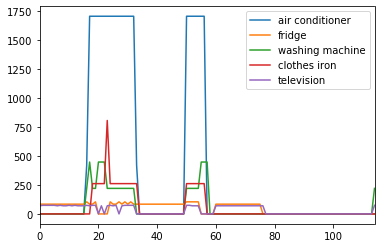

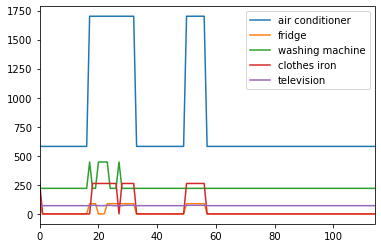

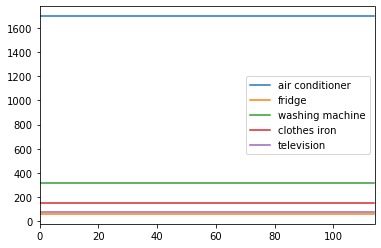

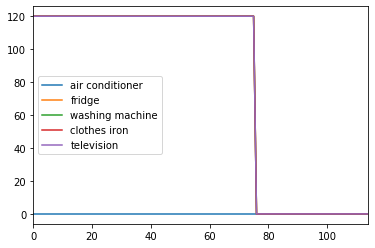

In [7]:
api_results_experiment_1 = API(experiment1)

In [8]:
df = (api_results_experiment_1.pred_overall['CO'])

Getting Predictions Dataframe

In [9]:
df

,air conditioner,fridge,washing machine,clothes iron,television
0,0.0,84.0,0.0,0.0,70.0
1,0.0,84.0,0.0,0.0,74.0
2,0.0,84.0,0.0,0.0,74.0
3,0.0,84.0,0.0,0.0,74.0
4,0.0,84.0,0.0,0.0,74.0
...,...,...,...,...,...
110,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0
